0.113
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9026 entries, 0 to 9025
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             9026 non-null   object 
 1   latitude         9026 non-null   float64
 2   longitude        9026 non-null   float64
 3   depth            9026 non-null   float64
 4   mag              9026 non-null   float64
 5   magType          9026 non-null   object 
 6   nst              7709 non-null   float64
 7   gap              7709 non-null   float64
 8   dmin             7708 non-null   float64
 9   rms              9025 non-null   float64
 10  net              9026 non-null   object 
 11  id               9026 non-null   object 
 12  updated          9026 non-null   object 
 13  place            9026 non-null   object 
 14  type             9026 non-null   object 
 15  horizontalError  7241 non-null   float64
 16  depthError       9026 non-null   float64
 17  magError

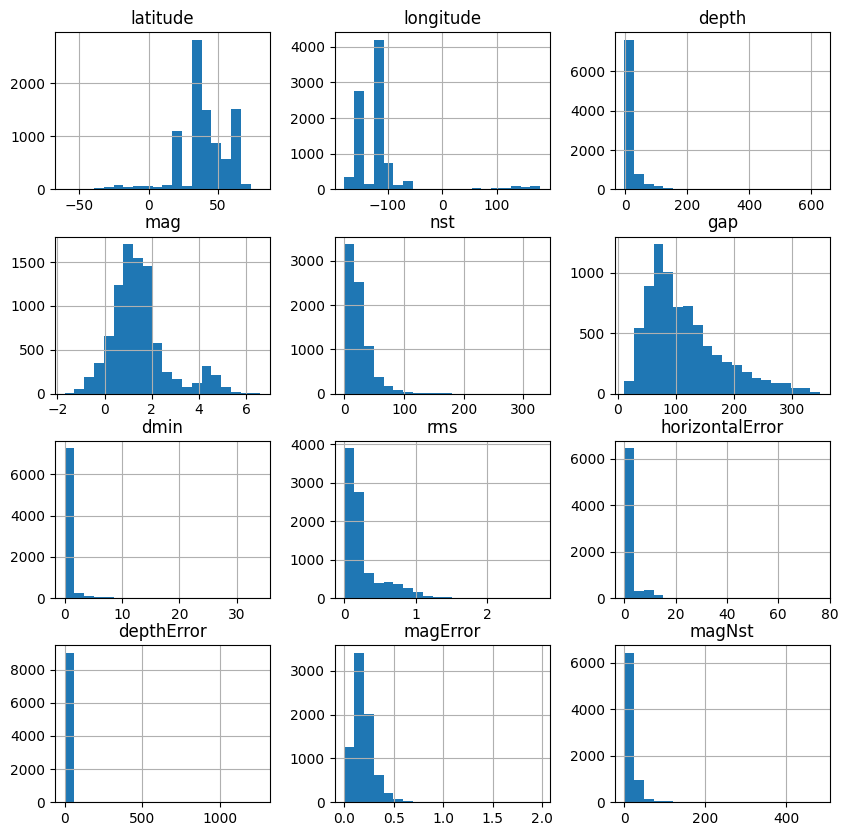

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# load earthquake data
eq = pd.read_csv("all_month.csv")

print(eq['magError'].quantile(0.25))

# see info on data types and null data
eq.info()

# print initial histograms to see trends in data
eq.hist(bins=20, figsize=(10,10))
plt.savefig("earthquake_plots/overall_hists.png")


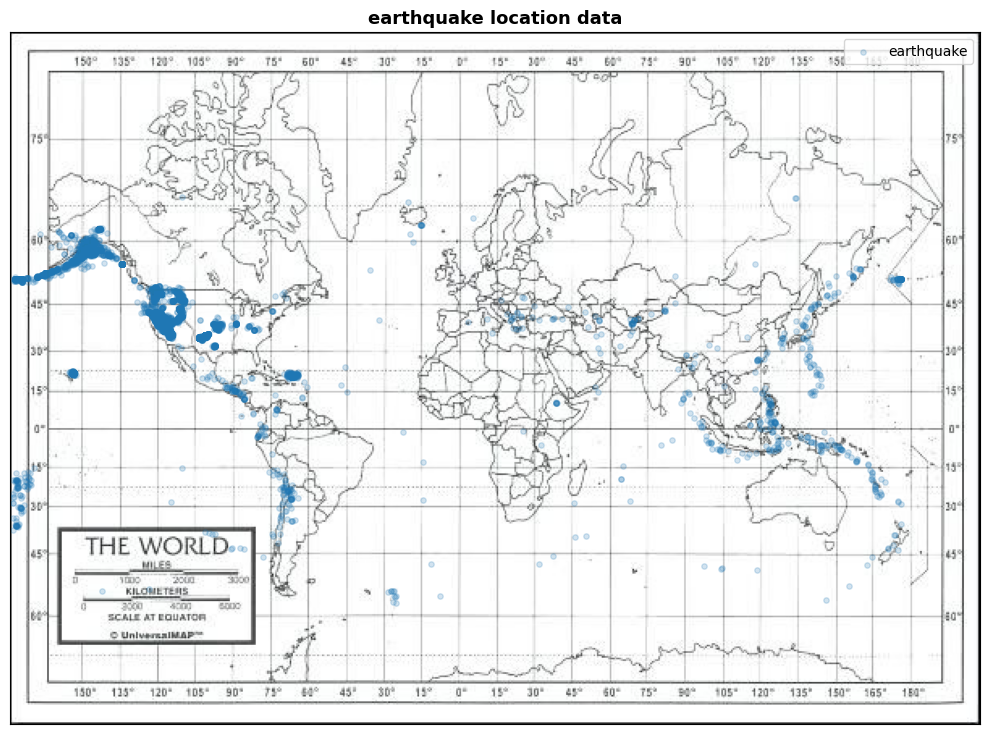

In [4]:
# Earthquake location data printed on top of world map
fig,ax = plt.subplots(figsize = (10,10))

# load world map image
im = plt.imread("world_map.jpg")
implot = plt.imshow(im)

# create scatter plot
ax.scatter(eq['longitude']*(550/360)+276, -eq['latitude']*(250/140)+245, alpha=0.2, label="earthquake", s=15)

# aesthetics
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
fig.tight_layout()
ax.set_title("earthquake location data", fontsize=13, fontweight='bold')

plt.savefig('earthquake_plots/earthquake_location.png')

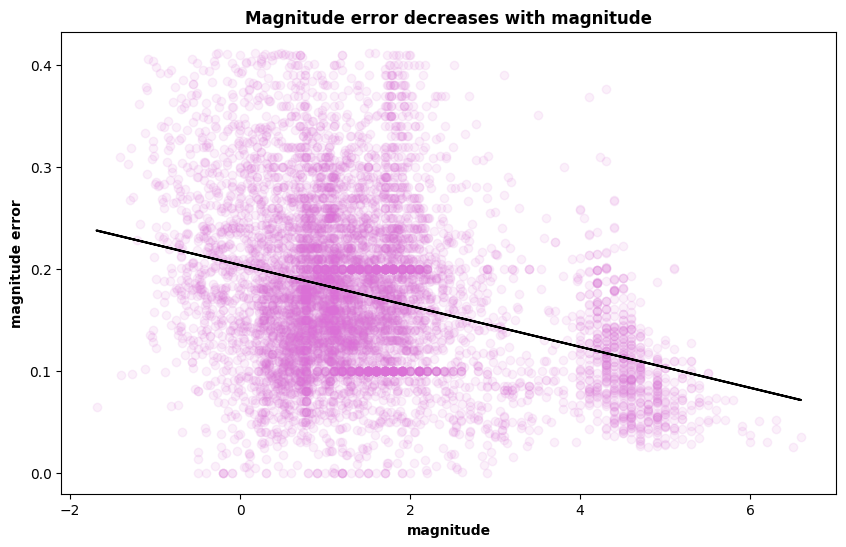

In [5]:
# plot of magnitude vs magnitude error
eq_no_mag_error = eq

# remove null data and outliers
Q25 = eq_no_mag_error['magError'].quantile(0.25)
Q75 = eq_no_mag_error['magError'].quantile(0.75)
IQR = Q75 - Q25
max_outlier = Q75 + IQR*1.5
min_outlier = Q25 - IQR*1.5 

for i in range(eq.shape[0]):
    if eq.loc[i,'magError'].astype(str) == 'nan' or eq.loc[i,'magError'] > max_outlier or eq.loc[i,'magError'] < min_outlier:
        eq_no_mag_error = eq_no_mag_error.drop([i])
eq_no_mag_error.reset_index(drop=True, inplace=True)

# create scatter plot of mag vs magerror
fig, ax = plt.subplots(figsize= (10,6))
ax.scatter(eq_no_mag_error['mag'], eq_no_mag_error['magError'], alpha=0.1, color = 'orchid')

# function to find line of best fit
def best_fit(X_data, Y_data):

    # find the means and number of data points
    x_mean = sum(X_data)/len(X_data)
    y_mean = sum(Y_data)/len(Y_data)
    n = len(X_data)

    # calculate numerator and denominator of b
    numerator = sum([(x-x_mean)*(y-y_mean) for x,y in zip(X_data, Y_data)])
    denominator = sum([(x-x_mean)**2 for x in X_data])
    
    # compute a and b
    b = numerator / denominator
    a = y_mean - b * x_mean

    return a, b

# find line of best fit
a, b = best_fit(eq_no_mag_error['mag'], eq_no_mag_error['magError'])
yfit = [a + b * xi for xi in eq_no_mag_error['mag']]

# plot line of best fit
plt.plot(eq_no_mag_error['mag'], yfit, color = 'black')

# aethetics
ax.set_ylabel("magnitude error", fontweight='bold')
ax.set_xlabel("magnitude", fontweight='bold')
ax.set_title("Magnitude error decreases with magnitude", fontweight='bold')

plt.savefig('earthquake_plots/mag_vs_mag_error.png')

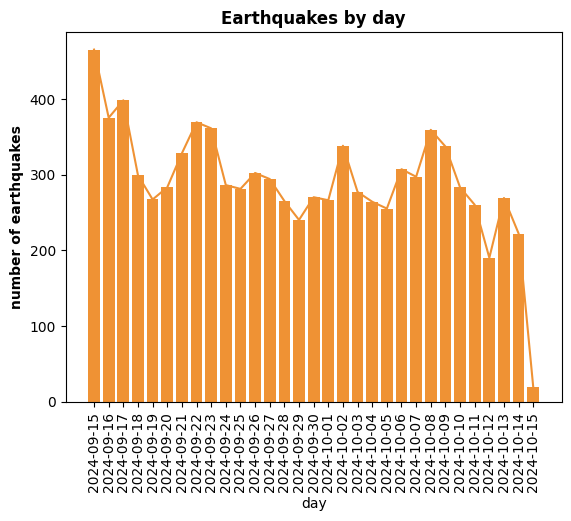

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

# load earthquake data
eq = pd.read_csv("all_month.csv")

# create date column in earthquake data
for i in range(eq.shape[0]):
    year_month_day = eq.loc[i,'time'].split("T")[0].split('-')
    eq.loc[i, 'day'] = year_month_day[0]+year_month_day[1]+year_month_day[2]
eq['day'] = pd.to_datetime(eq['day'], format='%Y%m%d')

# sort data by date column
eq_sorted_by_day= eq.sort_values(by='day').reset_index(drop=True)

# plot bar chart of number of earthquakes per day
fig, ax = plt.subplots()
ax.bar(eq_sorted_by_day['day'].value_counts().index, eq_sorted_by_day['day'].value_counts(),color="#EF9234")
sns.lineplot(x=eq_sorted_by_day['day'].value_counts().index, y=eq_sorted_by_day['day'].value_counts(),color="#EF9234")

# aesthetics
ax.set_ylabel("number of earthquakes", fontweight='bold')
ax.set_title("Earthquakes by day", fontweight='bold')
plt.xticks(ticks = eq_sorted_by_day['day'].value_counts().index, rotation=90)
plt.savefig('earthquake_plots/earthquakes_by_day.png')


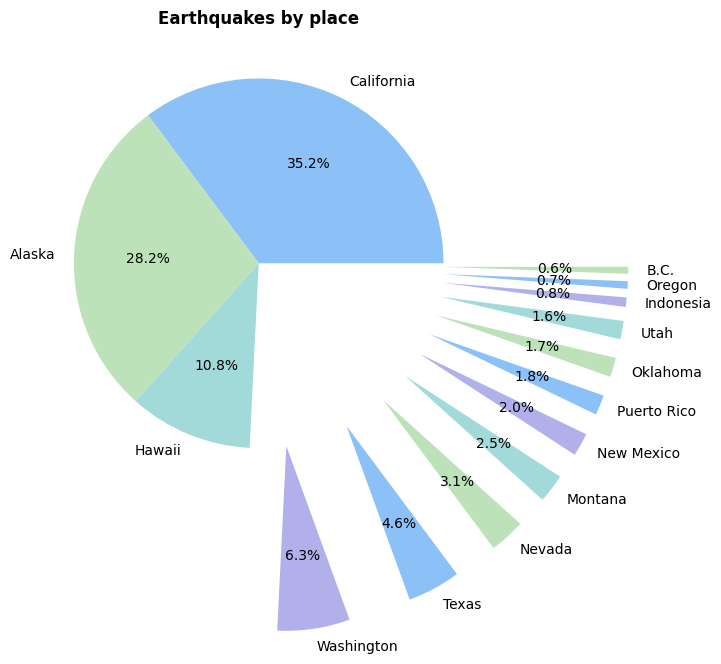

In [7]:
# earthquakes by location 
eq_by_state = eq

# find earthquake location from data in place column
for i in range(eq.shape[0]):
    try:
        eq_by_state.loc[i,'state'] = eq_by_state.loc[i, 'place'].split(", ")[1]
        if eq_by_state.loc[i,'state'] == 'CA':
            eq_by_state.loc[i,'state'] = 'California' # replace CA with California for consistency
    except:
        eq_by_state = eq_by_state.drop([i])

# sum up data for pie chart
data = eq_by_state['state'].value_counts() 

# remove outliers
for state in data.index:
    if data[state]<40:
        data.drop([state], inplace=True)

# aesthetics and print pie chart
colors = ["#8BC1F7","#BDE2B9","#A2D9D9","#B2B0EA"]
#colors = ["#e0c05e","#5ee069","#5c6ed6","#c966d4"]
explode = [ 1 if i < 0.1 else 0 for i in data/data.sum()]
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Earthquakes by place", fontweight='bold')
plt.pie(data, labels=data.index, autopct='%1.1f%%',colors=colors,explode = explode)
plt.savefig('earthquake_plots/earthquakes_by_place.png')


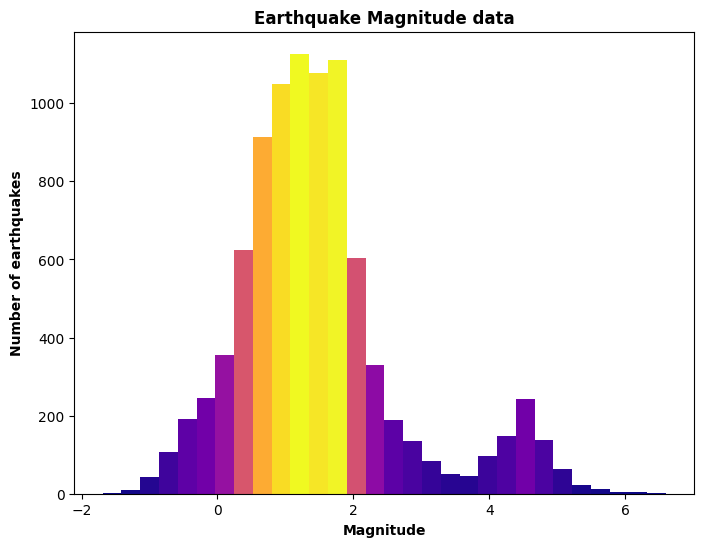

In [8]:
# magnitude histogram 

fig, ax = plt.subplots(figsize=(8,6))
N, bins, patches = ax.hist(eq['mag'], bins = 30)

# color bins of histogram acoording to height of bar
fracs = N/N.max()
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.plasma(thisfrac)
    thispatch.set_facecolor(color)

# aesthetics
ax.set_xlabel("Magnitude",fontweight="bold")
ax.set_ylabel("Number of earthquakes", fontweight="bold")
ax.set_title("Earthquake Magnitude data", fontweight="bold")
plt.savefig("earthquake_plots/magnitude.png")

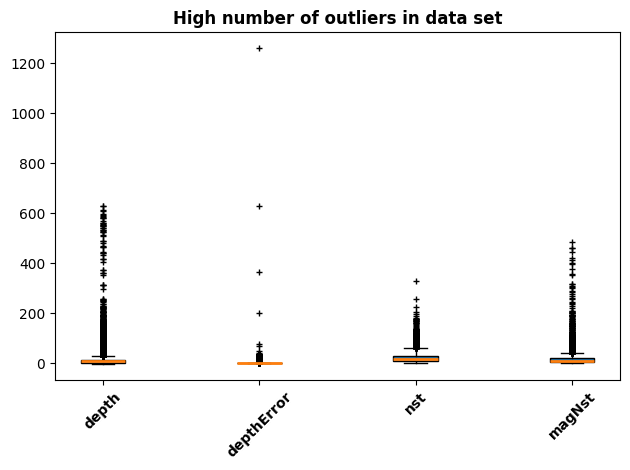

In [9]:
# box plot of depth etc. showing the high number of outliers, remove null data first using a for loop and drop
# list of columns to plot
columns = ['depth', 'depthError', 'nst', 'magNst']
# set up aethetics for box plots
outliers = dict(marker='+', markersize = 5, markerfacecolor='black')
medians = dict(linewidth=2)
fig, ax = plt.subplots()
x = 0

for column in columns:
    temp = eq[column]
    
    # remove null entries
    for i in range(temp.shape[0]):
        if temp[i].astype(str) == "nan":
            temp = temp.drop([i])
    
    # draw boxplot at appropriate position
    ax.boxplot(temp, positions=[x],
                widths=2,
                patch_artist=True,
                medianprops=medians,
                flierprops=outliers)
    x += 7

# aethetics
ax.set_xticks(np.arange(0,(len(columns)-1)*7+1,7))
ax.set_xticklabels(columns, fontweight='bold', rotation=45)
ax.set_title("High number of outliers in data set", fontweight='bold')
fig.tight_layout()
plt.savefig("earthquake_plots/box_plots_outliers.png")


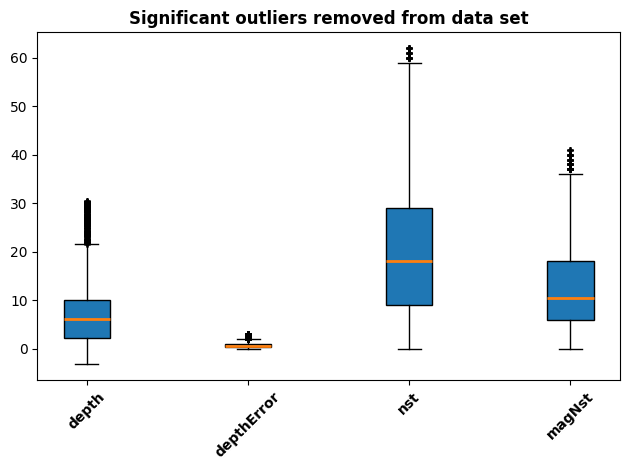

In [11]:
# remove outliers to see more detailed box plots

# list of columns to plot
columns = ['depth', 'depthError', 'nst', 'magNst']
# set up aethetics for box plots
outliers = dict(marker='+', markersize = 5, markerfacecolor='black')
medians = dict(linewidth=2)
fig, ax = plt.subplots()
x = 0

for column in columns:
    temp = eq[column]
    Q25 = temp.quantile(0.25)
    Q75 = temp.quantile(0.75)
    IQR = Q75 - Q25
    max_outlier = Q75 + 1.5*IQR
    min_outlier = Q25 - 1.5*IQR
    # remove null entries and outliers
    for i in range(temp.shape[0]):
        if temp[i].astype(str) == "nan":
            temp = temp.drop([i])
            continue
        if temp[i] > max_outlier or temp[i] < min_outlier:
            temp = temp.drop([i])
         
    # draw boxplot at appropriate position       
    ax.boxplot(temp, positions=[x],
                widths=2,
                patch_artist=True,
                medianprops=medians,
                flierprops=outliers)
    x += 7

#aethetics
ax.set_xticks(np.arange(0,(len(columns)-1)*7+1,7))
ax.set_xticklabels(columns, fontweight='bold', rotation=45)
ax.set_title("Significant outliers removed from data set", fontweight='bold')
fig.tight_layout()
plt.savefig("earthquake_plots/boxplots.png")